## Assignment-1:train.ipynb
### **Tanmoy Paul**
### *Roll no- MDS202246*

In [1]:
import numpy as np ## importing the library
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
## !pip install mlflow

In [3]:
# ML flow imports
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
from mlflow.tracking import MlflowClient

# Set the MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [4]:
## Reading the train and test data
train_data=pd.read_csv('train.csv') 
test_data=pd.read_csv('test.csv')

In [5]:
## Getting the predictor features and labels from the train and test set
X_train_sent,y_train=train_data['Processed_text'],train_data['spam']
X_test_sent,y_test=test_data['Processed_text'],test_data['spam']

### Feature Engineering

#### Here we will be using CountVectorizer. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train_sent)

CountVectorizer()

In [7]:
X_train=vectorizer.transform(X_train_sent) ## vectorizing train set
X_test=vectorizer.transform(X_test_sent) ## vectorizing test set

In [8]:
X_train.shape

(4556, 23147)

### Here we are balancing the Train set using "Over Sampling Method" for better training

In [9]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
X_train,y_train=smote.fit_resample(X_train,y_train)
y_train.value_counts()

0    3462
1    3462
Name: spam, dtype: int64

<Axes: xlabel='spam', ylabel='count'>

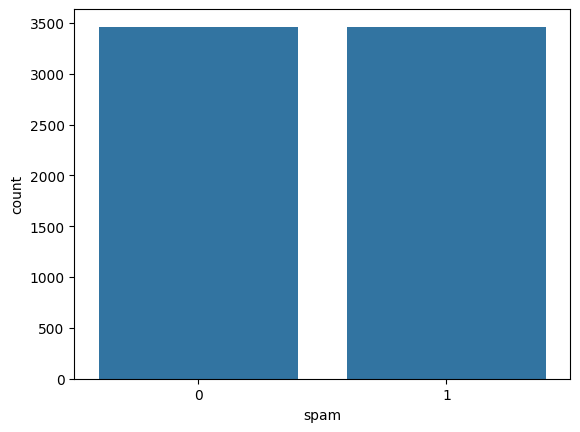

In [10]:
import seaborn as sns
sns.countplot(x=y_train)

### Now the Train set is balanced

In [11]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

### Model 1: Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression() ## Logistic Regression Model

#### GridSearchCV to find the Best Hyperparameter

In [13]:
params = {
    'penalty':['l2'] ,
    'C': [0.001,0.005,0.01,0.1,1], ## default is 1
}

grid = GridSearchCV(
    logreg,  # model
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # score to optimized
    cv=StratifiedKFold(n_splits=5),  # type of cross validation to use
)

In [14]:
logreg_detector = grid.fit(X_train, y_train)

#### Building and Tracking Model
**Log all the parameters and metric into MLflow**

In [15]:
gscv_mean_acc = logreg_detector.cv_results_['mean_test_score']
gscv_std_acc = logreg_detector.cv_results_['std_test_score']
gscv_params = logreg_detector.cv_results_['params']

In [16]:

for i in range(len(gscv_params)):
    run_mean_acc = gscv_mean_acc[i]
    run_std_acc = gscv_std_acc[i]
    run_params = gscv_params[i]

    with mlflow.start_run():
        # Extract parameters for the current run
        params = {}
        for key, value in run_params.items():
            if key.startswith("classifier__"):
                key = key[len("classifier__"):]
            params[key] = value

        # Fit Logistic Regression model with the current parameters
        logreg = LogisticRegression(**params).fit(X_train, y_train)
        
        # Log parameters
        for param, value in params.items():
            mlflow.log_param(param, value)
            
        # Log metrics
        mlflow.log_metric("Accuracy-Mean", run_mean_acc)
        mlflow.log_metric("Accuracy-StD", run_std_acc)
        
        # Calculate precision-recall curve metrics
        y_score = logreg.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_true=y_test,
                                                               probas_pred=y_score)
        auc_precision_recall = auc(recall, precision)
        mlflow.log_metric("AUC-PR", auc_precision_recall)
        
        # Log model
        mlflow.sklearn.log_model(logreg, "model")

In [31]:
mlflow.end_run() ## ending run

#### Registering the Best Logistic Regression Model

By comparing in the mlflow server we got the best hyperparameter as
C =1,penalty ='l2'

In [18]:
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
logreg=LogisticRegression(C=1,penalty='l2').fit(X_train,y_train)

# Model registering
if tracking_url_type_store != "file":
    mlflow.sklearn.log_model(logreg, "model", registered_model_name="Best_Logistic_Regression_Model")
else:
    mlflow.sklearn.log_model(logreg, "model")

Successfully registered model 'Best_Logistic_Regression_Model'.
2024/02/22 23:34:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Logistic_Regression_Model, version 1
Created version '1' of model 'Best_Logistic_Regression_Model'.


In [19]:
# Get list of registered models
client = mlflow.tracking.MlflowClient()
models = client.search_registered_models()

# Print names of registered models
for model in models:
    print(model.name) ## checking

Best_Logistic_Regression_Model


#### Checkout the Benchmark Logistic Regression Model and Printing AUC_PR

In [20]:
# Get the model URI
model_uri = "models:/Best_Logistic_Regression_Model/1"

# Load the scikit-learn model
best_logreg_model = mlflow.sklearn.load_model(model_uri=model_uri)

y_score = best_logreg_model.predict_proba(X_test)[:, 1]
# Calculating precision and recall
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_score)
# Calculating AUC-PR
auc_pr = auc(recall, precision)
print("BenchMark Logistic regression Model(AUC_PR):",auc_pr)

BenchMark Logistic regression Model(AUC_PR): 0.9829475110473382


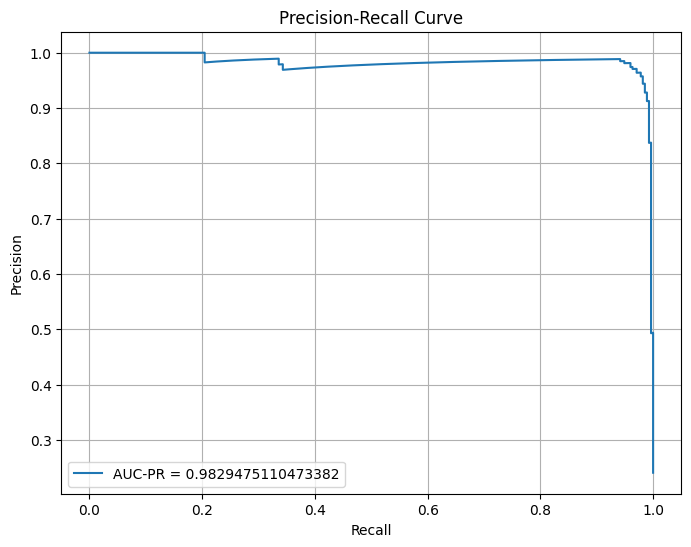

In [21]:
# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### *Scoring and evaluating on the Train set*

In [22]:
y_train_pred=best_logreg_model.predict(X_train) ## Predicting the Train set

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3462
           1       1.00      1.00      1.00      3462

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924



### *Score on the test set*

In [24]:
y_test_pred=best_logreg_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       865
           1       0.92      0.99      0.95       274

    accuracy                           0.98      1139
   macro avg       0.96      0.98      0.97      1139
weighted avg       0.98      0.98      0.98      1139



In [25]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[842  23]
 [  3 271]]


Confusion Matrix: 

[[true_negatives false_positives]                                                                                     
 [false_negatives true_positives]]

### Model 2: Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier() #random_forest_model

#### GridSearchCV to find the Best Hyperparameter

In [27]:
params = {
    'n_estimators':[30,50,100] ,
    'max_depth':[3,5,10,20,40,60],
}

grid = GridSearchCV(
    random_forest_model, 
    params,  
    refit=True,  
    n_jobs=-1, 
    scoring='accuracy',  
    cv=StratifiedKFold(n_splits=5),  
)

In [28]:
random_forest_detecter = grid.fit(X_train, y_train)

#### Building and Tracking Model
**Log all the parameters and metric into MLflow**

In [29]:
gscv_mean_acc = random_forest_detecter.cv_results_['mean_test_score']
gscv_std_acc = random_forest_detecter.cv_results_['std_test_score']
gscv_params = random_forest_detecter.cv_results_['params']

In [32]:

for i in range(len(gscv_params)):
    run_mean_acc = gscv_mean_acc[i]
    run_std_acc = gscv_std_acc[i]
    run_params = gscv_params[i]

    with mlflow.start_run():
        # Extract parameters for the current run
        params = {}
        for key, value in run_params.items():
            if key.startswith("classifier__"):
                key = key[len("classifier__"):]
            params[key] = value

        # Fit RandomForest Classifier model with the current parameters
        randomforest = RandomForestClassifier(**params).fit(X_train, y_train)
        
        # Log parameters
        for param, value in params.items():
            mlflow.log_param(param, value)
            
        # Log metrics
        mlflow.log_metric("Accuracy-Mean", run_mean_acc)
        mlflow.log_metric("Accuracy-StD", run_std_acc)
        
        # Calculate precision-recall curve metrics
        y_score = randomforest.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_true=y_test,
                                                               probas_pred=y_score)
        auc_precision_recall = auc(recall, precision)
        mlflow.log_metric("AUC-PR", auc_precision_recall)
        
        # Log model
        mlflow.sklearn.log_model(randomforest, "model")

In [47]:
mlflow.end_run() ## ending the run

#### Registering the Best Random forest Classifier Model

By comparing in the mlflow server we got the best hyperparameter as
max_depth=60,n_estimators=100

In [34]:
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
randomforest=RandomForestClassifier(max_depth=60,n_estimators=100).fit(X_train, y_train)

# Model registering
if tracking_url_type_store != "file":
    mlflow.sklearn.log_model(randomforest, "model", registered_model_name="Best_Random_Forest_Model")
else:
    mlflow.sklearn.log_model(randomforest, "model")

Successfully registered model 'Best_Random_Forest_Model'.
2024/02/22 23:39:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Random_Forest_Model, version 1
Created version '1' of model 'Best_Random_Forest_Model'.


In [35]:
# Get list of registered models
client = mlflow.tracking.MlflowClient()
models = client.search_registered_models()

# Print names of registered models
for model in models:
    print(model.name)

Best_Logistic_Regression_Model
Best_Random_Forest_Model


#### Checkout the Benchmark RandomForest Classifier Model and Printing AUC_PR

In [36]:
# Get the model URI
model_uri = "models:/Best_Random_Forest_Model/1"

# Load the scikit-learn model
best_randomforest_model = mlflow.sklearn.load_model(model_uri=model_uri)

# Assuming X_test is your test data
#best_logreg_model.fit(X_train,y_train)
y_score = best_randomforest_model.predict_proba(X_test)[:, 1]
# Calculating precision and recall
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_score)
# Calculating AUC-PR
auc_pr = auc(recall, precision)
print("BenchMark Random forest Classifier Model(AUC_PR):",auc_pr)

BenchMark Random forest Classifier Model(AUC_PR): 0.9861504113992015


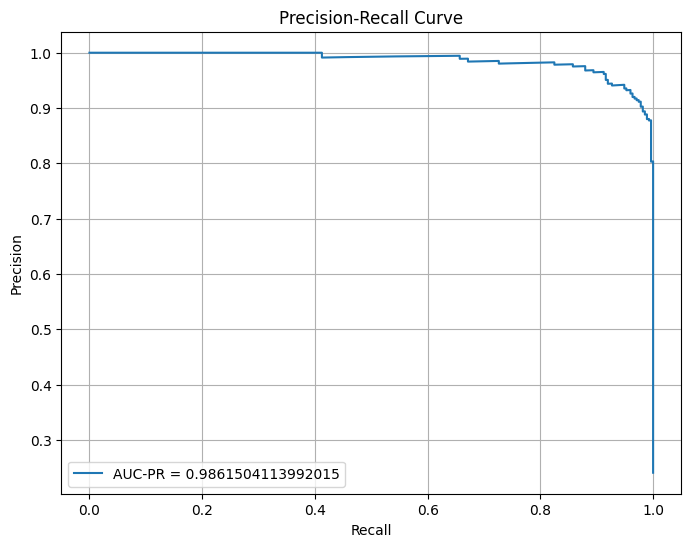

In [37]:
# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### *Scoring and evaluating on the Train set*

In [38]:
y_train_pred=best_randomforest_model.predict(X_train) ## Predicting the Train set

In [39]:

print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3462
           1       0.99      1.00      0.99      3462

    accuracy                           0.99      6924
   macro avg       0.99      0.99      0.99      6924
weighted avg       0.99      0.99      0.99      6924



### *Score on the test set*

In [40]:
y_test_pred=best_randomforest_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       865
           1       0.93      0.96      0.94       274

    accuracy                           0.97      1139
   macro avg       0.96      0.97      0.96      1139
weighted avg       0.97      0.97      0.97      1139



In [41]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[844  21]
 [ 11 263]]


### Model 3: SVC

In [42]:
from sklearn.svm import SVC
svc_model = SVC() #svc_model

#### GridSearchCV to find the Best Hyperparameter

In [43]:
params = {'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['rbf']
   }


grid = GridSearchCV(
    svc_model, 
    params,  
    refit=True,  
    n_jobs=-1, 
    scoring='accuracy',  
    cv=StratifiedKFold(n_splits=5),  
)

In [44]:
svc_detecter = grid.fit(X_train, y_train)

#### Building and Tracking Model
**Log all the parameters and metric into MLflow**

In [45]:
gscv_mean_acc = svc_detecter.cv_results_['mean_test_score']
gscv_std_acc = svc_detecter.cv_results_['std_test_score']
gscv_params = svc_detecter.cv_results_['params']

In [48]:

for i in range(len(gscv_params)):
    run_mean_acc = gscv_mean_acc[i]
    run_std_acc = gscv_std_acc[i]
    run_params = gscv_params[i]

    with mlflow.start_run():
        # Extract parameters for the current run
        params = {}
        for key, value in run_params.items():
            if key.startswith("classifier__"):
                key = key[len("classifier__"):]
            params[key] = value

        # Fit SVC model with the current parameters
        svc = SVC(probability=True,**params).fit(X_train, y_train)
        
        # Log parameters
        for param, value in params.items():
            mlflow.log_param(param, value)
            
        # Log metrics
        mlflow.log_metric("Accuracy-Mean", run_mean_acc)
        mlflow.log_metric("Accuracy-StD", run_std_acc)
        
        # Calculate precision-recall curve metrics
        y_score = svc.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_true=y_test,
                                                               probas_pred=y_score)
        auc_precision_recall = auc(recall, precision)
        mlflow.log_metric("AUC-PR", auc_precision_recall)
        
        # Log model
        mlflow.sklearn.log_model(svc, "model")

In [49]:
mlflow.end_run()

#### Registering the Best SVC Model

After comapring the Mlflow server we get the best hyper-parameter as C=1, gamma= 0.001, kernel= 'rbf'

In [50]:
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
svc_model=SVC(probability=True,C=1, gamma= 0.001, kernel= 'rbf').fit(X_train, y_train)

# Model registering
if tracking_url_type_store != "file":
    mlflow.sklearn.log_model(svc_model, "model", registered_model_name="Best_SVC_Model")
else:
    mlflow.sklearn.log_model(svc_model, "model")

Successfully registered model 'Best_SVC_Model'.
2024/02/22 23:43:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_SVC_Model, version 1
Created version '1' of model 'Best_SVC_Model'.


In [51]:
# Get list of registered models
client = mlflow.tracking.MlflowClient()
models = client.search_registered_models()

# Print names of registered models
for model in models:
    print(model.name)

Best_Logistic_Regression_Model
Best_Random_Forest_Model
Best_SVC_Model


#### Checkout the Benchmark RandomForest Classifier Model and Printing AUC_PR

In [52]:
# Get the model URI
model_uri = "models:/Best_SVC_Model/1"

# Load the scikit-learn model
best_svc_model = mlflow.sklearn.load_model(model_uri=model_uri)

y_score = best_svc_model.predict_proba(X_test)[:, 1]
# Calculating precision and recall
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=y_score)
# Calculating AUC-PR
auc_pr = auc(recall, precision)
print(auc_pr)

0.9835261903651563


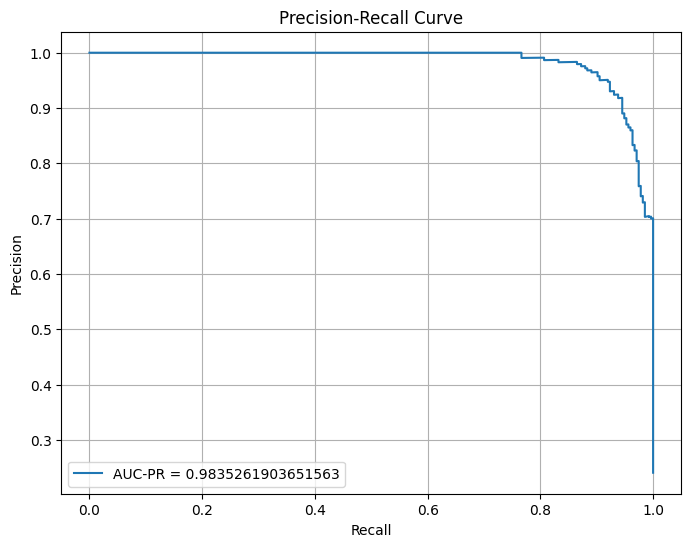

In [53]:
# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### *Scoring and evaluating on the Train set*

In [54]:
y_train_pred=best_svc_model.predict(X_train) ## Predicting the Train set

In [55]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3462
           1       0.94      1.00      0.97      3462

    accuracy                           0.97      6924
   macro avg       0.97      0.97      0.97      6924
weighted avg       0.97      0.97      0.97      6924



### *Score on the test set*

In [56]:
y_test_pred=best_svc_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       865
           1       0.81      0.97      0.88       274

    accuracy                           0.94      1139
   macro avg       0.90      0.95      0.92      1139
weighted avg       0.95      0.94      0.94      1139



In [57]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[801  64]
 [  8 266]]


## Conclusion

**Hence, we can observe that we are getting highest accuracy as 98% and largest area under Precision_Recall Curve for the Random Forest classifier Model. So we can choose  Random Forest classifier as our best model.**


In [58]:
import joblib
best_model = best_randomforest_model
filename = "best_model.joblib"
joblib.dump(best_model, filename)

['best_model.joblib']